In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *

In [ ]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid',
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)
# sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [ ]:
class Decoder(nn.Module):

    def __init__(
        self,
        input_size,
        output_horizon,
        encoder_hidden_size,
        decoder_hidden_size,
        output_size):
        super(Decoder, self).__init__()
        self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), \
                (output_horizon+1) * decoder_hidden_size)
        self.local_mlp = nn.Linear(decoder_hidden_size * 2 + input_size, output_size)
        self.decoder_hidden_size = decoder_hidden_size

    def forward(self, ht, xf):
        '''
        Args:
        ht (tensor): (1, hidden_size)
        xf (tensor): (output_horizon, num_features)
        '''
        num_ts, output_horizon, num_features = xf.size()
        num_ts, hidden_size = ht.size()
        ht = ht.unsqueeze(1)
        ht = ht.expand(num_ts, output_horizon, hidden_size)
        # inp = (xf + ht).view(batch_size, -1) # batch_size, hidden_size, output_horizon
        inp = torch.cat([xf, ht], dim=2).view(num_ts, -1)
        contexts = self.global_mlp(inp)
        contexts = contexts.view(num_ts, output_horizon+1, self.decoder_hidden_size)
        ca = contexts[:, -1, :].view(num_ts, -1)
        C = contexts[:, :-1, :]
        C = F.relu(C)
        y = []
        for i in range(output_horizon):
            ci = C[:, i, :].view(num_ts, -1)
            xfi = xf[:, i, :].view(num_ts, -1)
            inp = torch.cat([xfi, ci, ca], dim=1)
            out = self.local_mlp(inp) # num_ts, num_quantiles
            y.append(out.unsqueeze(1))
        y = torch.cat(y, dim=1) # batch_size, output_horizon, quantiles
        return y


In [ ]:
class MQRNN(nn.Module):

    def __init__(
        self,
        output_horizon,
        num_quantiles,
        input_size,
        embedding_size=10,
        encoder_hidden_size=64,
        encoder_n_layers=3,
        decoder_hidden_size=64
        ):
        '''
        args[""]:
        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        '''
        super(MQRNN, self).__init__()
        self.output_horizon = output_horizon
        self.encoder_hidden_size = encoder_hidden_size
        self.input_embed = nn.Linear(1, embedding_size) # time series embedding
        self.encoder = nn.LSTM(input_size + embedding_size, encoder_hidden_size, \
                    encoder_n_layers, bias=True, batch_first=True)
        self.decoder = Decoder(input_size, output_horizon, encoder_hidden_size,\
                    decoder_hidden_size, num_quantiles)

    def forward(self, X, y, Xf):
        '''
        Args:
        X (tensor like): shape (num_time_series, num_periods, num_features)
        y (tensor like): shape (num_time_series, num_periods)
        Xf (tensor like): shape (num_time_series, seq_len, num_features)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_periods, num_features = X.size()
        y = y.unsqueeze(2)
        y = self.input_embed(y)
        x = torch.cat([X, y], dim=2)
        # x = x.unsqueeze(0) # batch, seq_len, embed + num_features
        _, (h, c) = self.encoder(x)
        ht = h[-1, :, :]
        # global mlp
        ht = F.relu(ht)
        ypred = self.decoder(ht, Xf)
        return ypred


In [ ]:
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len, :]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf


In [ ]:
def train(
    X,
    y,
    args,
    quantiles
    ):
    num_ts, num_periods, num_features = X.shape
    num_quantiles = len(quantiles)
    model = MQRNN(
        args["seq_len"],
        num_quantiles,
        num_features,
        args["embedding_size"],
        args["encoder_hidden_size"],
        args["n_layers"],
        args["decoder_hidden_size"]
        )
    optimizer = Adam(model.parameters(), lr=args["lr"])
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    yscaler = None
    if args["standard_scaler"]:
        yscaler = util.StandardScaler()
    elif args["log_scaler"]:
        yscaler = util.LogScaler()
    elif args["mean_scaler"]:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)
    num_obs_to_train = args["num_obs_to_train"]
    seq_len = args["seq_len"]
    progress = ProgressBar()
    for epoch in progress(range(args["num_epoches"])):
        # print("Epoch {} start...".format(epoch))
        for step in range(args["step_per_epoch"]):
            X_train_batch, y_train_batch, Xf, yf = batch_generator(Xtr, ytr,
                    num_obs_to_train, args["seq_len"], args["batch_size"])
            X_train_tensor = torch.from_numpy(X_train_batch).float()
            y_train_tensor = torch.from_numpy(y_train_batch).float()
            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred = model(X_train_tensor, y_train_tensor, Xf)

            # quantile loss
            loss = torch.zeros_like(yf)
            num_ts = Xf.size(0)
            for q, rho in enumerate(quantiles):
                ypred_rho = ypred[:, :, q].view(num_ts, -1)
                e = ypred_rho - yf
                loss += torch.max(rho * e, (rho - 1) * e)
            loss = loss.mean()

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    mape_list = []
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    yf_test = yte[:, -seq_len:]
    ypred = model(X_test, y_test, Xf_test) # (1, num_quantiles, output_horizon)
    ypred = ypred.data.numpy()
    if yscaler is not None:
        ypred = yscaler.inverse_transform(ypred)
    ypred = np.maximum(0, ypred)

    # P50 quantile MAPE
    mape = util.MAPE(yf_test, ypred[:, :, 1])
    print("MAPE: {}".format(mape))
    mape_list.append(mape)

    if args["show_plot"]:
        show_idx = 0
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], ypred[show_idx, :, 1], "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=ypred[show_idx, :, 0], y2=ypred[show_idx, :, 2], alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[show_idx, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list, yscaler, model, Xte, yte



## Data

In [ ]:
data = pd.read_csv("../data/load.csv", parse_dates=["date_time"])

In [ ]:
dates= pd.DataFrame(pd.date_range('2017-08-01 00:00:00', '2020-02-29 23:00:00',  freq='H'))
data['date_time']= dates

In [ ]:
data.set_index(['date_time'], inplace=True)
data.head()

,conso_global
date_time,
2017-08-01 00:00:00,3.03
2017-08-01 01:00:00,2.86
2017-08-01 02:00:00,2.85
2017-08-01 03:00:00,3.36
2017-08-01 04:00:00,3.03


<AxesSubplot:xlabel='date_time'>

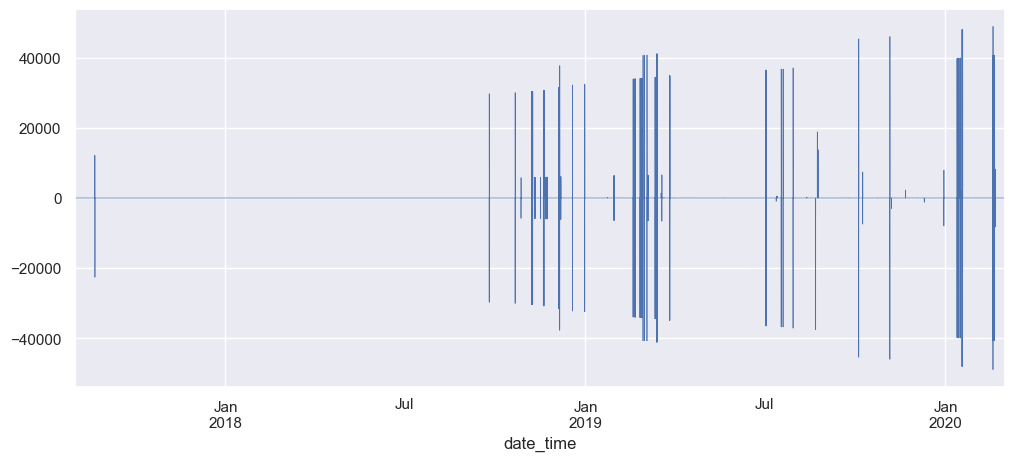

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)})
data['conso_global'].plot(linewidth=0.5)

In [ ]:
import math

Q1 = data['conso_global'].quantile(0.25)
Q3 = data['conso_global'].quantile(0.75)
IQR = Q3 - Q1

data[(data['conso_global'] < (Q1 - 1.5 * IQR)) | (data['conso_global'] > (Q3 + 1.5 * IQR))] = math.nan

# print('Lenght of outliers: {}'.format(len(rr)))
print('UIF = {} and LIF = {}'.format(Q3 + 1.5 * IQR,Q1 - 1.5 * IQR))

UIF = 5.555250000000001 and LIF = -2.8051500000000003


In [ ]:
#Replace anomalies with the values of the last days (same time)
one_week = 24*7
for idx in range(data.shape[0]):
    if (np.isnan(data.iloc[idx]['conso_global'])) or (data.iloc[idx]['conso_global']<0) :
        data.iloc[idx]['conso_global'] = data.iloc[idx-one_week]['conso_global']

<AxesSubplot:xlabel='date_time'>

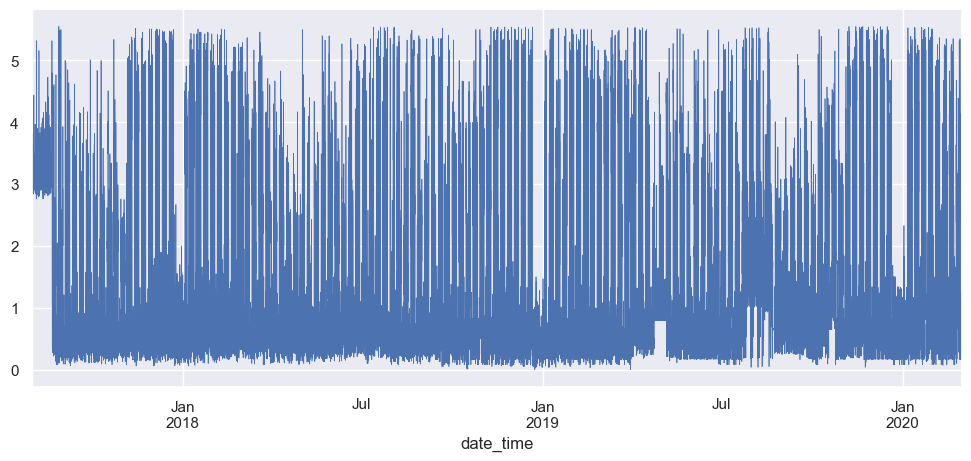

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
data['conso_global'].plot(linewidth=0.5)

In [ ]:
data["date"]= data.index
data

,conso_global,date
date_time,,
2017-08-01 00:00:00,3.0300,2017-08-01 00:00:00
2017-08-01 01:00:00,2.8600,2017-08-01 01:00:00
2017-08-01 02:00:00,2.8500,2017-08-01 02:00:00
2017-08-01 03:00:00,3.3600,2017-08-01 03:00:00
2017-08-01 04:00:00,3.0300,2017-08-01 04:00:00
...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00


In [ ]:
data[data.conso_global.isnull()==True]

,conso_global,date
date_time,,


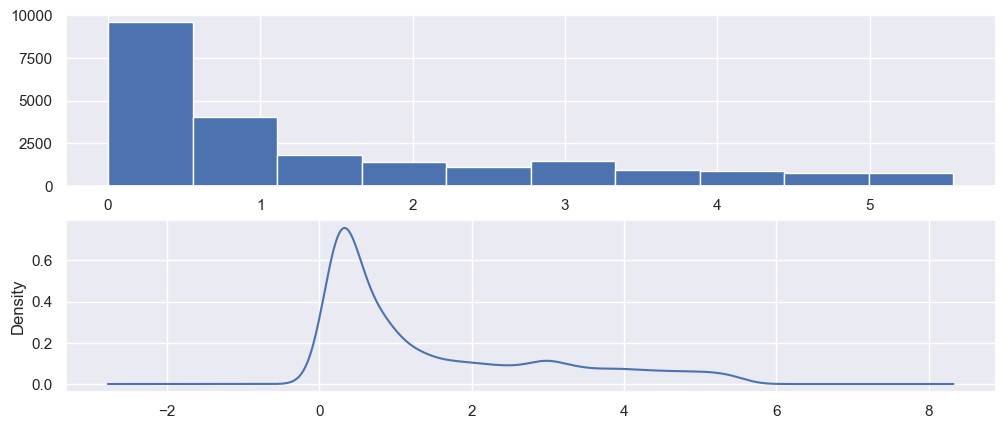

In [ ]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data.conso_global.hist()
pyplot.subplot(212)
data.conso_global.plot(kind='kde')
pyplot.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(data.conso_global).reshape(-1, 1))
scaled_data= scaler.transform(np.array(data.conso_global).reshape(-1, 1))
data['load'] = np.array(scaled_data).reshape(1, -1)[0]


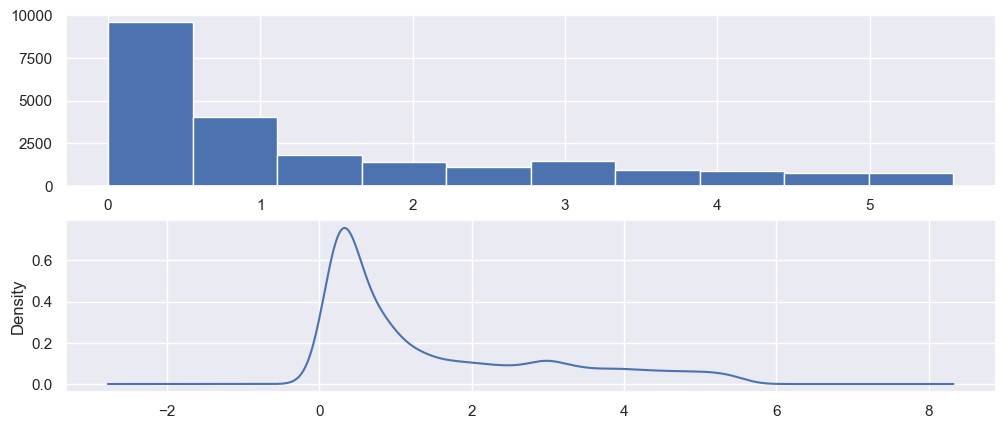

In [ ]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data.conso_global.hist()
pyplot.subplot(212)
data.conso_global.plot(kind='kde')
pyplot.show()

In [ ]:
# from scipy.stats import boxcox
# bcx_target, lam = boxcox(data["load"])
# bcx_target= pd.DataFrame(bcx_target, columns=['trsf'])
# #lam is the best lambda for the distribution

In [ ]:
# bcx_target

In [ ]:
# from pandas import Series
# from matplotlib import pyplot
# pyplot.figure(1)
# pyplot.subplot(211)
# bcx_target.trsf.hist()
# pyplot.subplot(212)
# bcx_target.trsf.plot(kind='kde')
# pyplot.show()

In [ ]:
# data['target'] = bcx_target['trsf']

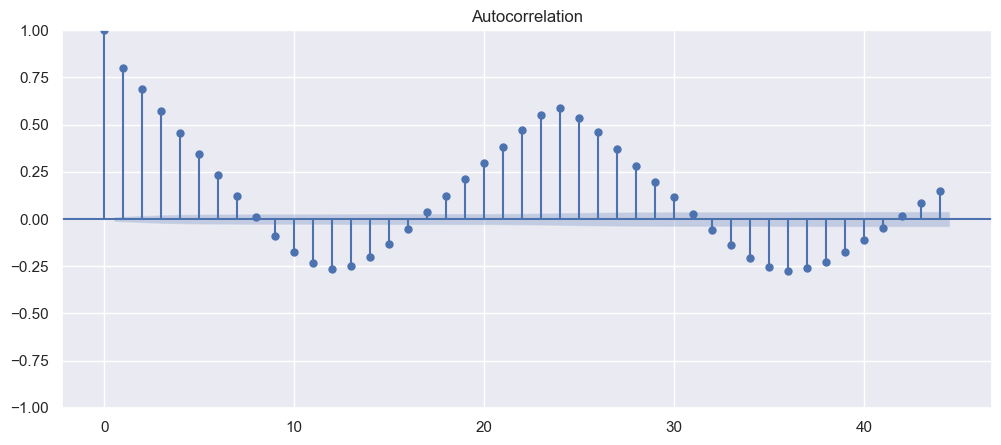

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.load)
pyplot.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(data.load)

In [ ]:
acf_values

array([ 1.        ,  0.80219499,  0.68776655,  0.57262549,  0.45831446,
        0.34202917,  0.23262153,  0.12330869,  0.01224051, -0.08995464,
       -0.17324741, -0.23150926, -0.26554598, -0.24667325, -0.20120192,
       -0.13273997, -0.05043634,  0.03507286,  0.12288685,  0.21141133,
        0.29623769,  0.38354317,  0.47127086,  0.54968008,  0.58770985,
        0.53757546,  0.462845  ,  0.37098798,  0.28243834,  0.19658296,
        0.11447311,  0.02707407, -0.05899801, -0.13710201, -0.20602348,
       -0.25181856, -0.27739366, -0.26117673, -0.22826079, -0.17365568,
       -0.11045333, -0.04657161,  0.01776588,  0.08421422])

In [ ]:
data

,conso_global,date,load
date_time,,,
2017-08-01 00:00:00,3.0300,2017-08-01 00:00:00,0.545857
2017-08-01 01:00:00,2.8600,2017-08-01 01:00:00,0.515232
2017-08-01 02:00:00,2.8500,2017-08-01 02:00:00,0.513430
2017-08-01 03:00:00,3.3600,2017-08-01 03:00:00,0.605307
2017-08-01 04:00:00,3.0300,2017-08-01 04:00:00,0.545857
...,...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00,0.120683
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00,0.059450
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00,0.059450


In [ ]:
pd.to_datetime(data['date'])

date_time
2017-08-01 00:00:00   2017-08-01 00:00:00
2017-08-01 01:00:00   2017-08-01 01:00:00
2017-08-01 02:00:00   2017-08-01 02:00:00
2017-08-01 03:00:00   2017-08-01 03:00:00
2017-08-01 04:00:00   2017-08-01 04:00:00
                              ...        
2020-02-29 19:00:00   2020-02-29 19:00:00
2020-02-29 20:00:00   2020-02-29 20:00:00
2020-02-29 21:00:00   2020-02-29 21:00:00
2020-02-29 22:00:00   2020-02-29 22:00:00
2020-02-29 23:00:00   2020-02-29 23:00:00
Name: date, Length: 22632, dtype: datetime64[ns]

In [ ]:
data["year"] = data["date"].apply(lambda x: x.year)

In [ ]:
data["hour"] = data["date"].apply(lambda x: x.hour)

In [ ]:
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)

In [ ]:
data["month"] = data["date"].apply(lambda x: x.month)

In [ ]:
data.set_index(pd.to_datetime(data['date']), inplace=True)

In [ ]:
import holidays

de_holidays = holidays.France()
cet_dates = pd.Series(data.index, index=data.index)
data["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
data["holiday"] = data["holiday"].astype(int)

In [ ]:
#lags
counter = np.arange(1,25)
# lags = np.arange(24*7, 24*8)
lags=[72, 73, 23+72, 24+72, 25+72, 47+72, 48+72]
lags = np.arange(72, 72+24)

lag_cols = [f"conso_lag_{cn}" for cn in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["load"].shift(lag)

In [ ]:
data.head(5)

,conso_global,date,load,year,hour,day_of_week,month,holiday,conso_lag_72,conso_lag_73,...,conso_lag_86,conso_lag_87,conso_lag_88,conso_lag_89,conso_lag_90,conso_lag_91,conso_lag_92,conso_lag_93,conso_lag_94,conso_lag_95
date,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,3.03,2017-08-01 00:00:00,0.545857,2017,0,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 01:00:00,2.86,2017-08-01 01:00:00,0.515232,2017,1,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 02:00:00,2.85,2017-08-01 02:00:00,0.513430,2017,2,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 03:00:00,3.36,2017-08-01 03:00:00,0.605307,2017,3,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 04:00:00,3.03,2017-08-01 04:00:00,0.545857,2017,4,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.dropna(inplace=True)

In [ ]:
data

,conso_global,date,load,year,hour,day_of_week,month,holiday,conso_lag_72,conso_lag_73,...,conso_lag_86,conso_lag_87,conso_lag_88,conso_lag_89,conso_lag_90,conso_lag_91,conso_lag_92,conso_lag_93,conso_lag_94,conso_lag_95
date,,,,,,,,,,,,,,,,,,,,,
2017-08-04 23:00:00,3.0300,2017-08-04 23:00:00,0.545857,2017,23,4,8,0,0.644940,0.632330,...,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232,0.545857
2017-08-05 00:00:00,3.6600,2017-08-05 00:00:00,0.659353,2017,0,5,8,0,0.556666,0.644940,...,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232
2017-08-05 01:00:00,2.9000,2017-08-05 01:00:00,0.522438,2017,1,5,8,0,0.554865,0.556666,...,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430
2017-08-05 02:00:00,2.9000,2017-08-05 02:00:00,0.522438,2017,2,5,8,0,0.556666,0.554865,...,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307
2017-08-05 03:00:00,2.9000,2017-08-05 03:00:00,0.522438,2017,3,5,8,0,0.535048,0.556666,...,0.616116,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00,0.120683,2020,19,5,2,0,0.090075,0.272010,...,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639,0.300870,0.178367
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00,0.059450,2020,20,5,2,0,0.090075,0.090075,...,0.696464,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639,0.300870
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00,0.059450,2020,21,5,2,0,0.059450,0.090075,...,0.731953,0.696464,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639


In [ ]:
features = ["hour", "day_of_week", "month", "holiday"]
# hours = pd.get_dummies(data["hour"])
# dows = pd.get_dummies(data["day_of_week"])
hours = data["hour"]
dows = data["day_of_week"]
months = data["month"]
holidays = data["holiday"]
lags = data[lag_cols]
#,
X = np.c_[np.asarray(hours), np.asarray(dows), np.asarray(holidays)]# , np.asarray(lags)
num_features = X.shape[1]
num_periods = len(data)
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(data["load"]).reshape((-1, num_periods))
quantiles = [0.1, 0.5, 0.9]

In [ ]:
data.head(5)

,conso_global,date,load,year,hour,day_of_week,month,holiday,conso_lag_72,conso_lag_73,...,conso_lag_86,conso_lag_87,conso_lag_88,conso_lag_89,conso_lag_90,conso_lag_91,conso_lag_92,conso_lag_93,conso_lag_94,conso_lag_95
date,,,,,,,,,,,,,,,,,,,,,
2017-08-04 23:00:00,3.03,2017-08-04 23:00:00,0.545857,2017,23,4,8,0,0.644940,0.632330,...,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232,0.545857
2017-08-05 00:00:00,3.66,2017-08-05 00:00:00,0.659353,2017,0,5,8,0,0.556666,0.644940,...,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232
2017-08-05 01:00:00,2.90,2017-08-05 01:00:00,0.522438,2017,1,5,8,0,0.554865,0.556666,...,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430
2017-08-05 02:00:00,2.90,2017-08-05 02:00:00,0.522438,2017,2,5,8,0,0.556666,0.554865,...,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307
2017-08-05 03:00:00,2.90,2017-08-05 03:00:00,0.522438,2017,3,5,8,0,0.535048,0.556666,...,0.616116,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857


In [ ]:
# args= { "num_epoches":100, "step_per_epoch": 3, "n_layers": 1, "encoder_hidden_size":64, "decoder_hidden_size":64  , "num_obs_to_train": 24*7, "show_plot": True, "run_test":True, "embedding_size": 10, "hidden_size": 50, "seq_len": 24, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": 64, "sample_size": 100 }

In [ ]:
# seq_len = 24*7
# num_obs_to_train = 24*7

In [ ]:
# look_back_days = 7
# look_ahead_days = 1
# sample_size=100

# num_epoches=100
# step_per_epoch= 5
# batch_size= 32
# step_per_epoch= 5

# n_layers= 3
# embedding_size= 1
# encoder_hidden_size= 20
# decoder_hidden_size= 50
# hidden_size= 15
# ############change the lstm sizes! 40cells 2 layers  nlaeyrs and embedding
# num_obs_to_train=1
# seq_len = 24

# args= { "encoder_hidden_size":encoder_hidden_size, "decoder_hidden_size":decoder_hidden_size, "num_epoches":num_epoches, "step_per_epoch": step_per_epoch, "n_layers": n_layers, "likelihood": "g", "num_obs_to_train": num_obs_to_train, "show_plot": True, "run_test":True, "embedding_size": embedding_size, "hidden_size": hidden_size, "seq_len": seq_len, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": batch_size, "sample_size": sample_size }

In [ ]:
# {'n_layers': 10,
#  'encoder_hidden_size': 20,
#  'decoder_hidden_size': 50,
#  'hidden_size': 47}

In [ ]:
look_back_days = 7
look_ahead_days = 1
sample_size=100

num_epoches=100
step_per_epoch= 5
batch_size= 32
step_per_epoch= 5

n_layers= 10
embedding_size= 1
encoder_hidden_size= 20
decoder_hidden_size= 50
hidden_size= 47
############change the lstm sizes! 40cells 2 layers  nlaeyrs and embedding
num_obs_to_train=24
seq_len = 7*24

args= { "encoder_hidden_size":encoder_hidden_size, "decoder_hidden_size":decoder_hidden_size, "num_epoches":num_epoches, "step_per_epoch": step_per_epoch, "n_layers": n_layers, "likelihood": "g", "num_obs_to_train": num_obs_to_train, "show_plot": True, "run_test":True, "embedding_size": embedding_size, "hidden_size": hidden_size, "seq_len": seq_len, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": batch_size, "sample_size": sample_size }

100% |########################################################################|


MAPE: 1.2640897025169768


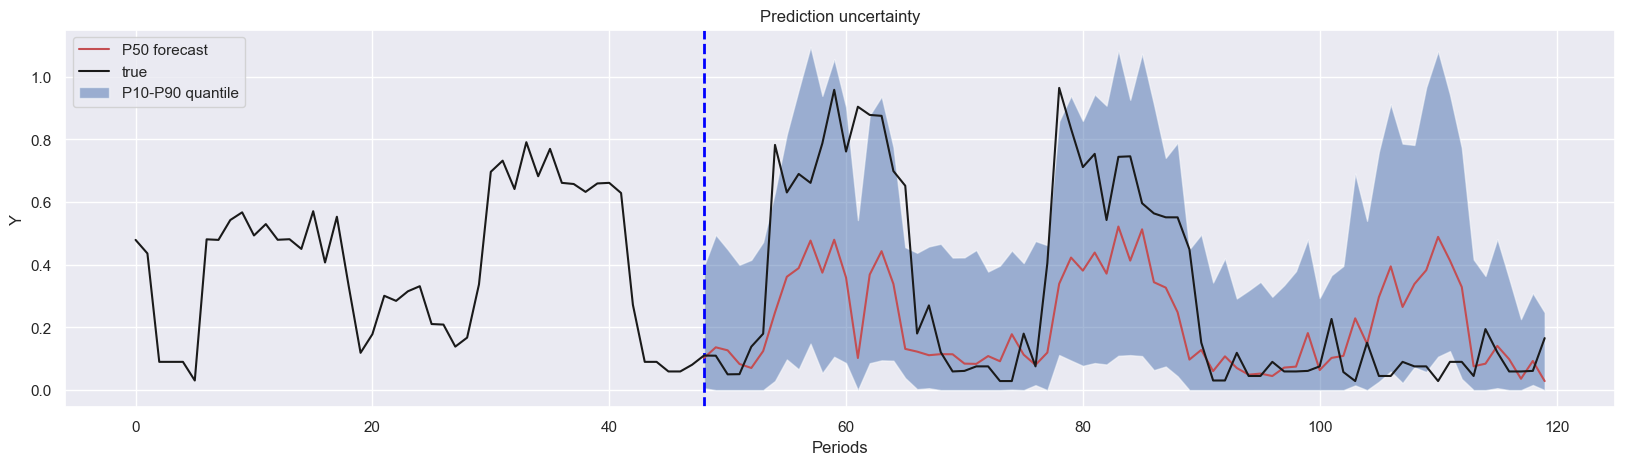

In [ ]:
losses, mape_list, yscaler, model, Xte, yte  = train(X, y, args, quantiles)

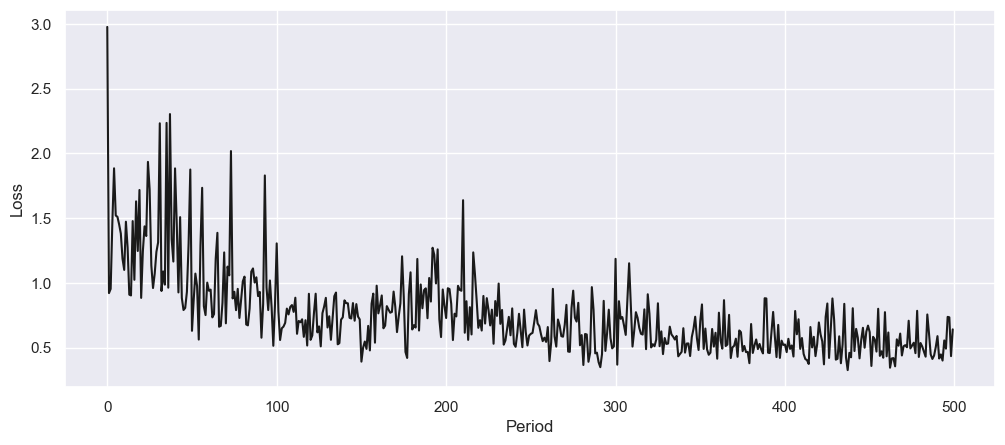

In [ ]:
plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

In [ ]:
num_ts, _, num_features = Xte.shape

In [ ]:
# test

p50_list=[]
p90_list=[]
p10_list=[]
true_values=[]
pp = (Xte.shape[1]-seq_len) //num_obs_to_train
# pp=30
for k in tqdm(range(pp)):

    mape_list = []
    #create the test sets
    X_test = Xte[:, num_obs_to_train*k:num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    y_test = yte[:, num_obs_to_train*k:num_obs_to_train*(k+1)].reshape((num_ts, -1))
    yf_test = yte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1)].reshape((num_ts, -1))


    # select skus with most top K
    if yscaler is not None:
        y_test = yscaler.transform(y_test)

    y_pred= model(X_test, y_test, Xf_test)
    y_pred = y_pred.data.numpy()
    if yscaler is not None:
        y_pred = yscaler.inverse_transform(y_pred)
    y_pred = np.maximum(0, y_pred)

    p50_list.append(y_pred[0,:,1])
    p90_list.append(y_pred[0,:,2])
    p10_list.append(y_pred[0,:,0])
    true_values.append(yf_test)


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:07<00:00, 17.86it/s]


In [ ]:
p90_list= np.array(p90_list).flatten()
p50_list= np.array(p50_list).flatten()
p10_list= np.array(p10_list).flatten()
true_values= np.array(true_values).flatten()

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f"MAE: {mean_absolute_error(true_values, p50_list)}, RMSE: {mean_squared_error(true_values, p50_list) ** 0.5}, MAPE: {mean_absolute_percentage_error(true_values, p50_list)}")
print( "The accuracy of the model is: %f" %r2_score(true_values, p50_list))

MAE: 0.1449213203541589, RMSE: 0.20401296399098706, MAPE: 1.1063251057635526
The accuracy of the model is: 0.374136


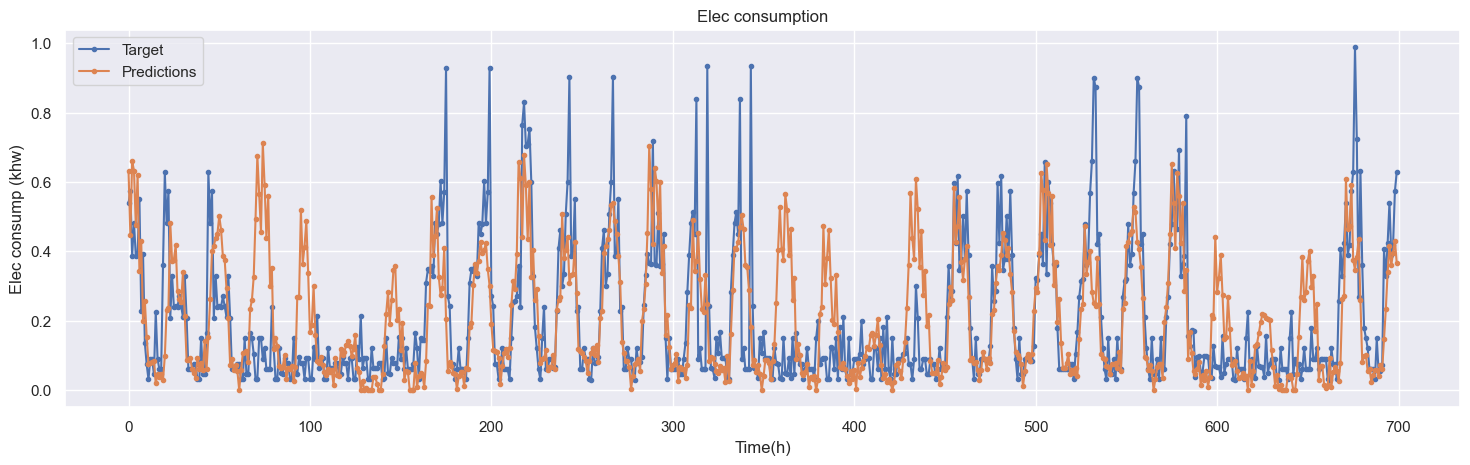

In [ ]:
plt.figure(figsize=(18,5))

plt.plot(true_values[100:800], marker='.',label='Target')
plt.plot(p50_list[100:800], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()